# Classification

In [1]:
import geopandas as gpd

blocks = gpd.read_parquet('blocks.parquet')

In [2]:
def identify_category(series):
    if (series['build_floor_area']<=1) and (series['transport']>=0.9):
        return 'invalid'
    if series.site_area>=1000000:
        return 'large'
    return 'normal'

blocks['category'] = blocks.apply(identify_category, axis=1)

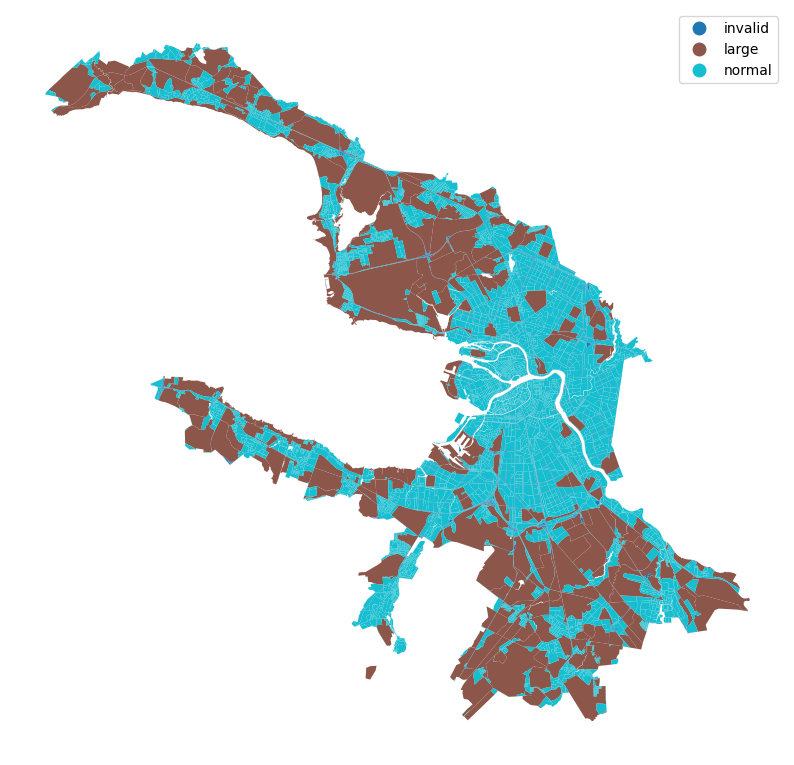

In [3]:
blocks.plot('category',legend=True, figsize=(10,10)).set_axis_off()

In [13]:
import itertools
from sklearn.metrics import accuracy_score
from blocksnet.blocks.classification.core import BlocksClassifier
from blocksnet.machine_learning.strategy.catboost.classification_strategy import CatBoostClassificationStrategy

# Шаг 1: Сетка параметров
param_grid = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6],
    'l2_leaf_reg': [1, 5],
    'bootstrap_type': ['Bayesian', 'Bernoulli'],
    'grow_policy': ['SymmetricTree', 'Lossguide'],
}

# Общие фиксированные параметры
base_params = {
    'random_seed': 42,
    'verbose': 0,
    'loss_function': 'MultiClass',
    'eval_metric': 'Accuracy'
}

# Шаг 2: Перебираем все комбинации
keys, values = zip(*param_grid.items())
param_combinations = list(itertools.product(*values))

results = []

# Шаг 3: Обучение по всем комбинациям
for i, combo in enumerate(param_combinations, start=1):
    params = dict(zip(keys, combo))
    params.update(base_params)

    # Спец. параметр: bagging_temperature только для Bayesian
    if params['bootstrap_type'] == 'Bayesian':
        params['bagging_temperature'] = 0.5
    else:
        params.pop('bagging_temperature', None)  # удалить если есть

    print(f"\n▶️ [{i}/{len(param_combinations)}] {params}")
    
    try:
        strategy = CatBoostClassificationStrategy(params)
        classifier = BlocksClassifier(strategy)
        score = classifier.train(blocks)  # blocks — твой GeoDataFrame
        print(f"✅ Accuracy: {score:.4f}")
        results.append((score, params))
    except Exception as e:
        print(f"❌ Ошибка в стратегии: {e}")
        continue

# Шаг 4: Вывод лучших
results.sort(reverse=True, key=lambda x: x[0])
print("\n🏆 Топ-5 конфигураций:")
for i, (score, cfg) in enumerate(results[:5], 1):
    print(f"{i}. Accuracy = {score:.4f} | {cfg}")


▶️ [1/96] {'iterations': 500, 'learning_rate': 0.01, 'depth': 4, 'l2_leaf_reg': 1, 'bootstrap_type': 'Bayesian', 'grow_policy': 'SymmetricTree', 'random_seed': 42, 'verbose': 0, 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'bagging_temperature': 0.5}
✅ Accuracy: 0.8032

▶️ [2/96] {'iterations': 500, 'learning_rate': 0.01, 'depth': 4, 'l2_leaf_reg': 1, 'bootstrap_type': 'Bayesian', 'grow_policy': 'Lossguide', 'random_seed': 42, 'verbose': 0, 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy', 'bagging_temperature': 0.5}
✅ Accuracy: 0.8051

▶️ [3/96] {'iterations': 500, 'learning_rate': 0.01, 'depth': 4, 'l2_leaf_reg': 1, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'random_seed': 42, 'verbose': 0, 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy'}
✅ Accuracy: 0.8032

▶️ [4/96] {'iterations': 500, 'learning_rate': 0.01, 'depth': 4, 'l2_leaf_reg': 1, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'Lossguide', 'random_seed': 42, 'verbose': 0, 'lo